# Random forest p53 classification

In [1]:
## Imports

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

## 1. Loading the data

remove unnecessary quotes from csv files (result from edgeR)
```
tr -d '"' < meta_data_with_norm_factors.csv > meta.csv
tr -d '"' < count_data_EdgeR_preprocessed.csv > count.csv
```

In [2]:
dataset = pd.read_csv("Data/count.csv", index_col = 0)
metadata = pd.read_csv("Data/meta.csv", index_col = 0)

In [3]:
dataset.set_index('cases.0.samples.0.submitter_id', inplace=True, drop=True)
metadata.set_index('cases.0.samples.0.submitter_id', inplace=True, drop=True)

In [4]:
len(dataset)

9609

### Exploration

In [5]:
value_counts = metadata['cases.0.project.project_id'].value_counts()

# Get the total number of different values
total_unique_values = metadata['cases.0.project.project_id'].nunique()

print("Cancers and their counts:")
print(value_counts)

print("\nTotal number of different cancer types:", total_unique_values)

Cancers and their counts:
cases.0.project.project_id
TCGA-BRCA    1022
TCGA-UCEC     533
TCGA-LGG      523
TCGA-LUAD     522
TCGA-HNSC     497
TCGA-THCA     496
TCGA-PRAD     494
TCGA-LUSC     483
TCGA-SKCM     467
TCGA-COAD     412
TCGA-BLCA     407
TCGA-STAD     372
TCGA-KIRC     370
TCGA-LIHC     360
TCGA-CESC     288
TCGA-KIRP     281
TCGA-OV       257
TCGA-SARC     237
TCGA-PCPG     183
TCGA-PAAD     169
TCGA-ESCA     162
TCGA-GBM      159
TCGA-TGCT     150
TCGA-READ     146
TCGA-THYM     119
TCGA-MESO      82
TCGA-UVM       80
TCGA-ACC       79
TCGA-LAML      65
TCGA-KICH      65
TCGA-UCS       57
TCGA-DLBC      37
TCGA-CHOL      35
Name: count, dtype: int64

Total number of different cancer types: 33


### Concatenate with labels

In [6]:
## Labels 
metadata = metadata[~metadata.index.duplicated(keep='first')] ## remove some duplicated rows

## Make sure that rows (samples) in the counts matrix (dataset) are in the same order as the metadata
dataset = dataset.loc[metadata.index]
## Add the class (1/0) as final column to the dataset
dataset['mutated'] = metadata.iloc[:,-2]

In [7]:
# dummies for the cancer types

cancer_dummies = pd.get_dummies(metadata['cases.0.project.project_id'])
dataset = pd.concat([dataset, cancer_dummies], axis=1)

In [8]:
# Split data into X and y
X = dataset.loc[:, dataset.columns != 'mutated']  # Features
y = dataset['mutated']  # Target variable

In [9]:
# ration of mutated vs non mutated

sum(y)/len(y)

0.3717627401837928

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 2. Spatial data simulation & data splitting

In [11]:
import numpy as np
import pandas as pd

def CreateSTSim(X, y, num_circles=6, grid_size=64, circle_radius=[4, 9], seed=None):
    np.random.seed(seed)

    node_features = np.zeros((grid_size, grid_size, X.shape[1]))  # Node features
    node_labels = np.zeros((grid_size, grid_size), dtype=int)  # Node labels
    node_names = list()

    radii = np.random.randint(circle_radius[0], circle_radius[1], size=num_circles)
    circle_midpoints = np.random.randint(circle_radius[0], grid_size - circle_radius[0], size=(num_circles, 2))

    data1 = X[y == 1]
    data0 = X[y == 0]

    for i in range(grid_size):
        for j in range(grid_size):
            x = np.array([i, j])
            distances = np.linalg.norm(x - circle_midpoints, axis=1)

            if np.any(distances <= radii):
                node_labels[i, j] = 1
                random_index = np.random.choice(len(data1))
                node_features[i, j] = data1.iloc[random_index].values
                node_names.append(data1.index[random_index])
            else:
                random_index = np.random.choice(len(data0))
                node_features[i, j] = data0.iloc[random_index].values
                node_names.append(data0.index[random_index])

    spatial_X = pd.DataFrame(node_features.reshape(-1, X.shape[1]), columns=X.columns)
    spatial_y = pd.Series(node_labels.flatten(), name='mutated')

    return spatial_X, spatial_y.values


In [15]:
# Spatial data simulation for training set
grid_size = 64
train_spatial_X, train_spatial_y = CreateSTSim(X_train, y_train, num_circles=10, grid_size=grid_size, circle_radius=[6, 10], seed=1)

In [16]:
# ratio mutated vs non mutated (try to match this to original ratio)
sum(train_spatial_y)/len(train_spatial_y)

0.35205078125

In [17]:
# Spatial data simulation for test set
test_spatial_X, test_spatial_y = CreateSTSim(X_test, y_test, num_circles=10, grid_size=grid_size, circle_radius=[6, 10], seed=1)

## 3. Random forest model

In [18]:
# Model training using simulated training data
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_spatial_X, train_spatial_y)

RandomForestClassifier(random_state=42)

In [19]:
#Predict on the simulated test set
predictions_test = rf_classifier.predict(test_spatial_X)

## 4. Evaluation

In [20]:
# Functions

def evaluate_model(predictions, y_test):
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy on Test Data: {accuracy}")

    print("Classification Report on Test Data:")
    print(classification_report(y_test, predictions))

    print("Confusion Matrix on Test Data:")
    conf_matrix = confusion_matrix(y_test, predictions)
    print(conf_matrix)

    return accuracy, conf_matrix

def plot_roc_curve(predictions, y_test):
    fpr, tpr, _ = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC on Test Data = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve on Test Data')
    plt.legend(loc='lower right')
    plt.show()

def plot_precision_recall_curve(preds_test, y_test):
    precision, recall, _ = precision_recall_curve(y_test, preds_test)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

def plot_feature_importances(rf_classifier, X, top_n=100):
    feature_importances = rf_classifier.feature_importances_
    sorted_indices = np.argsort(feature_importances)[::-1]

    top_feature_importances = feature_importances[sorted_indices][:top_n]
    top_feature_names = X.columns[sorted_indices][:top_n]

    plt.figure(figsize=(15, 8))
    plt.bar(range(top_n), top_feature_importances, align='center')
    plt.xticks(range(top_n), top_feature_names, rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title(f'Top {top_n} Feature Importances')
    plt.tight_layout()
    plt.show()

def plot_label_comparison(actual_labels, predicted_labels, grid_size):
    # Reshape the Pandas Series into a NumPy array
    actual_labels_grid = actual_labels.reshape(grid_size, grid_size)

    # Reshape predicted labels back into a grid
    predicted_grid = predicted_labels.reshape(grid_size, grid_size)

    # Create subplots to compare actual labels and predicted labels
    plt.figure(figsize=(12, 6))

    # Plot for actual labels
    plt.subplot(1, 2, 1)
    plt.imshow(actual_labels_grid, cmap='coolwarm', interpolation='nearest')
    plt.title('Actual Labels (Test Set)')
    plt.colorbar()

    # Plot for predicted labels
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_grid, cmap='coolwarm', interpolation='nearest')
    plt.title('Predicted Labels')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

In [21]:
accuracy_test, conf_matrix_test = evaluate_model(predictions_test, test_spatial_y)

Accuracy on Test Data: 0.842041015625
Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      2654
           1       0.83      0.70      0.76      1442

    accuracy                           0.84      4096
   macro avg       0.84      0.81      0.82      4096
weighted avg       0.84      0.84      0.84      4096

Confusion Matrix on Test Data:
[[2445  209]
 [ 438 1004]]


## 5. Visualisations

In [22]:
probabilities = rf_classifier.predict_proba(test_spatial_X)[:, 1]

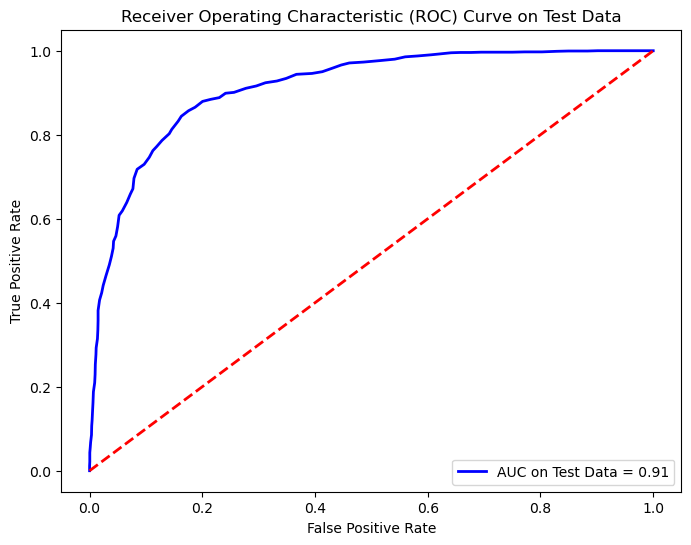

In [23]:
plot_roc_curve(probabilities, test_spatial_y)

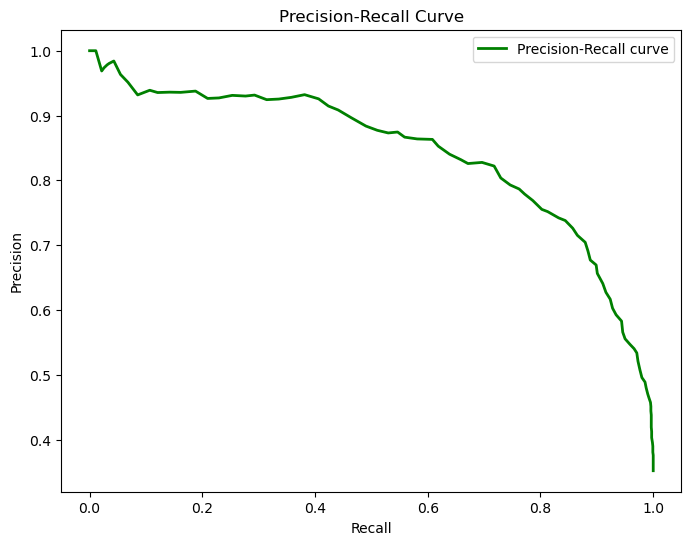

In [24]:
plot_precision_recall_curve(probabilities, test_spatial_y)

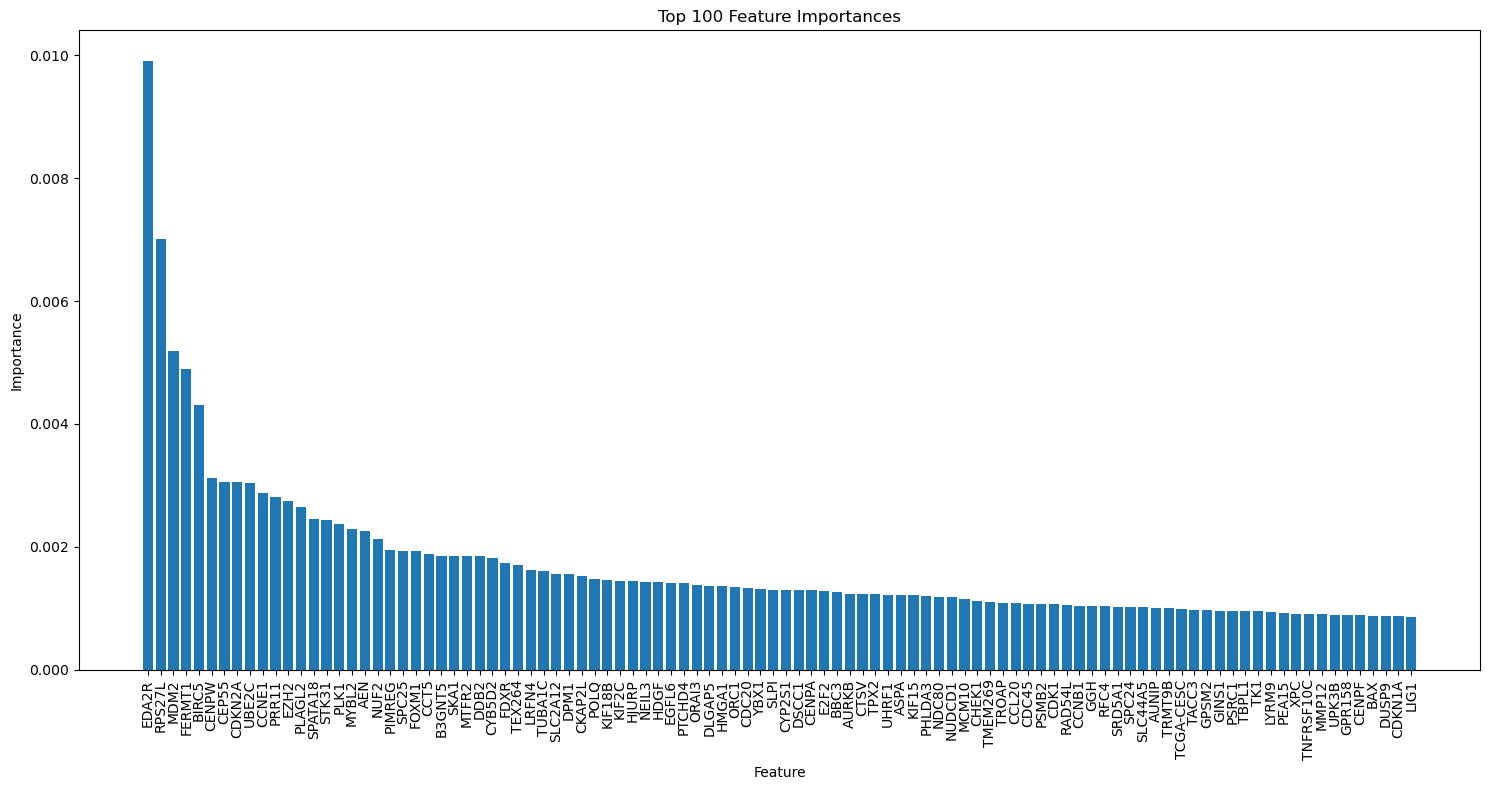

In [25]:
plot_feature_importances(rf_classifier, X_test)

Mainly p53 regulators

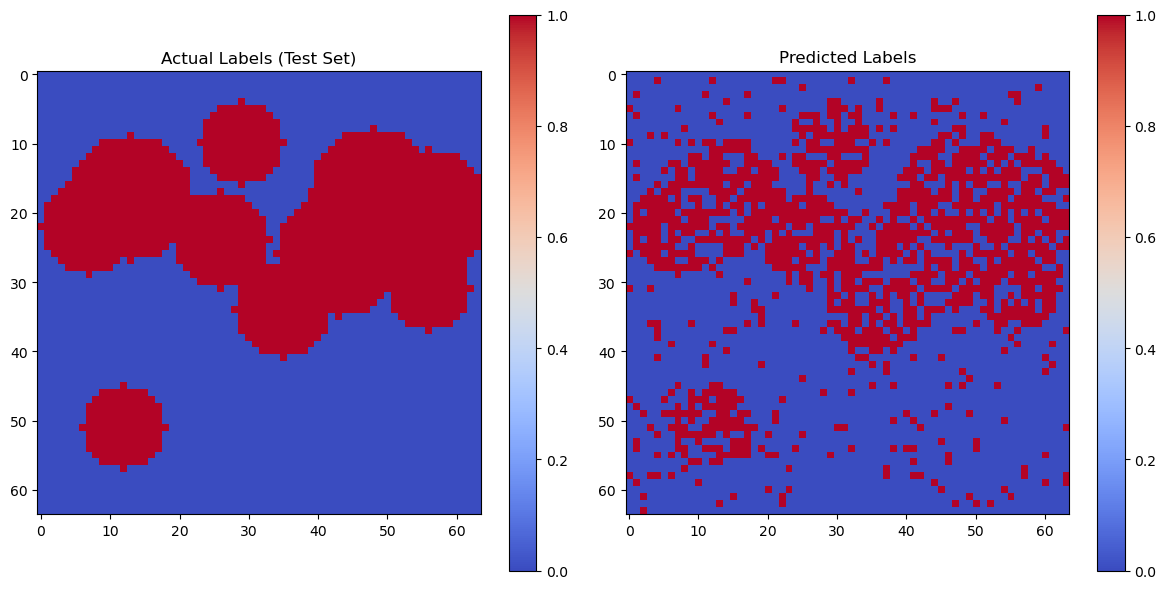

In [26]:
plot_label_comparison(test_spatial_y, predictions_test, grid_size)

# ADDENDUM : Using only most important genes

### Bootstrap to find ideal number of top features

In [27]:
# Get feature importances from the trained model
feature_importances = rf_classifier.feature_importances_

# Exclude the 'mutated' column from feature names
feature_names = X_train.columns[X_train.columns != 'mutated']  

# Sort feature indices based on importances
sorted_indices = np.argsort(feature_importances)[::-1]

num_top_features = 2001  # Set the number of top features to use
top_feature_indices = sorted_indices[:num_top_features]
top_feature_names = feature_names[top_feature_indices]

# The code for feature importances, selecting top features, and model training remains the same as before


In [29]:
# Lists to store results
accuracies = []
precisions_0 = []
precisions_1 = []
recalls_0 = []
recalls_1 = []
f1_scores_0 = []
f1_scores_1 = []
optimal_num_features_list = []

# Iterate through different numbers of top features
for num_top_features in range(50, 200, 50):
    # Create a new dataset using only the top features
    X_train_top = train_spatial_X[top_feature_names[:num_top_features]]
    X_test_top = test_spatial_X[top_feature_names[:num_top_features]]

    # Re-train the Random Forest model using only the selected top features
    rf_classifier_top = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier_top.fit(X_train_top, train_spatial_y)

    # Predict using the model trained on top features
    predictions_test_top = rf_classifier_top.predict(X_test_top)

    # Calculate accuracy
    accuracy_test_top = accuracy_score(test_spatial_y, predictions_test_top)
    accuracies.append(accuracy_test_top)
    optimal_num_features_list.append(num_top_features)  # Store the number of features used

    # Additional evaluation metrics for the model using top features
    report = classification_report(test_spatial_y, predictions_test_top, output_dict=True)
    precisions_0.append(report['0']['precision'])
    precisions_1.append(report['1']['precision'])
    recalls_0.append(report['0']['recall'])
    recalls_1.append(report['1']['recall'])
    f1_scores_0.append(report['0']['f1-score'])
    f1_scores_1.append(report['1']['f1-score'])

# Find the index of the maximum accuracy
max_accuracy_index = np.argmax(accuracies)
optimal_num_features = optimal_num_features_list[max_accuracy_index]

# Print results
print(f"Optimal number of features for maximum accuracy: {optimal_num_features}")
print(f"Maximum accuracy achieved: {accuracies[max_accuracy_index]}")
print(f"Precision for class 0: {precisions_0[max_accuracy_index]}")
print(f"Precision for class 1: {precisions_1[max_accuracy_index]}")
print(f"Recall for class 0: {recalls_0[max_accuracy_index]}")
print(f"Recall for class 1: {recalls_1[max_accuracy_index]}")
print(f"F1-score for class 0: {f1_scores_0[max_accuracy_index]}")
print(f"F1-score for class 1: {f1_scores_1[max_accuracy_index]}")

Optimal number of features for maximum accuracy: 100
Maximum accuracy achieved: 0.878173828125
Precision for class 0: 0.8974548137218739
Precision for class 1: 0.8404332129963898
Recall for class 0: 0.9167294649585531
Recall for class 1: 0.8072122052704577
F1-score for class 0: 0.9069897483690587
F1-score for class 1: 0.8234877962504421


100 is the optimal number

### Use top 100 features

In [30]:
# Get feature importances from the trained model
feature_importances = rf_classifier.feature_importances_
feature_names = X_train.columns[X_train.columns != 'mutated']  
sorted_indices = np.argsort(feature_importances)[::-1]
num_top_features = 100
top_feature_indices = sorted_indices[:num_top_features]
top_feature_names = feature_names[top_feature_indices]

X_train_top = train_spatial_X[top_feature_names[:num_top_features]]
X_test_top = test_spatial_X[top_feature_names[:num_top_features]]

In [31]:
# Re-train the Random Forest model using only the selected top features
rf_classifier_top = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_top.fit(X_train_top, train_spatial_y)

RandomForestClassifier(random_state=42)

In [32]:
# Predict using the model trained on top features
predictions_test_top = rf_classifier_top.predict(X_test_top)

In [33]:
accuracy_test, conf_matrix_test = evaluate_model(predictions_test_top, test_spatial_y)

Accuracy on Test Data: 0.878173828125
Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2654
           1       0.84      0.81      0.82      1442

    accuracy                           0.88      4096
   macro avg       0.87      0.86      0.87      4096
weighted avg       0.88      0.88      0.88      4096

Confusion Matrix on Test Data:
[[2433  221]
 [ 278 1164]]


In [34]:
probabilities = rf_classifier_top.predict_proba(X_test_top)[:, 1]

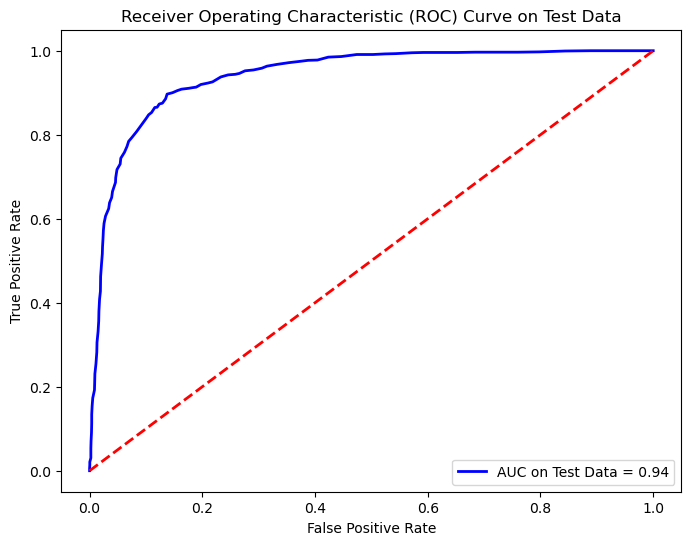

In [35]:
plot_roc_curve(probabilities, test_spatial_y)

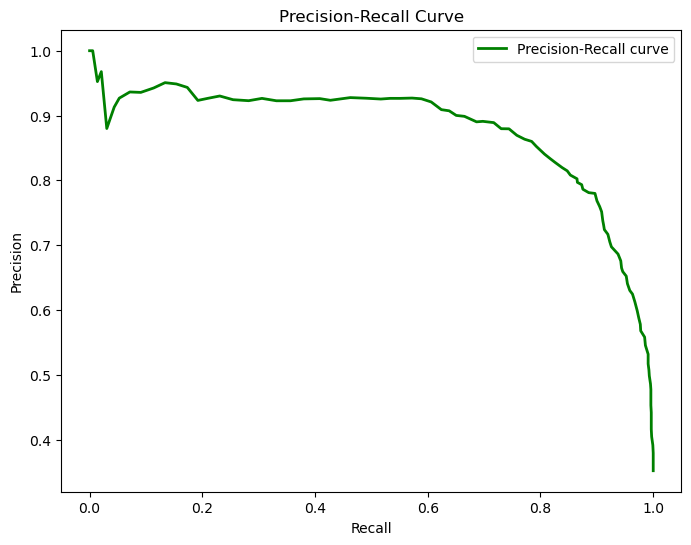

In [36]:
plot_precision_recall_curve(probabilities, test_spatial_y)

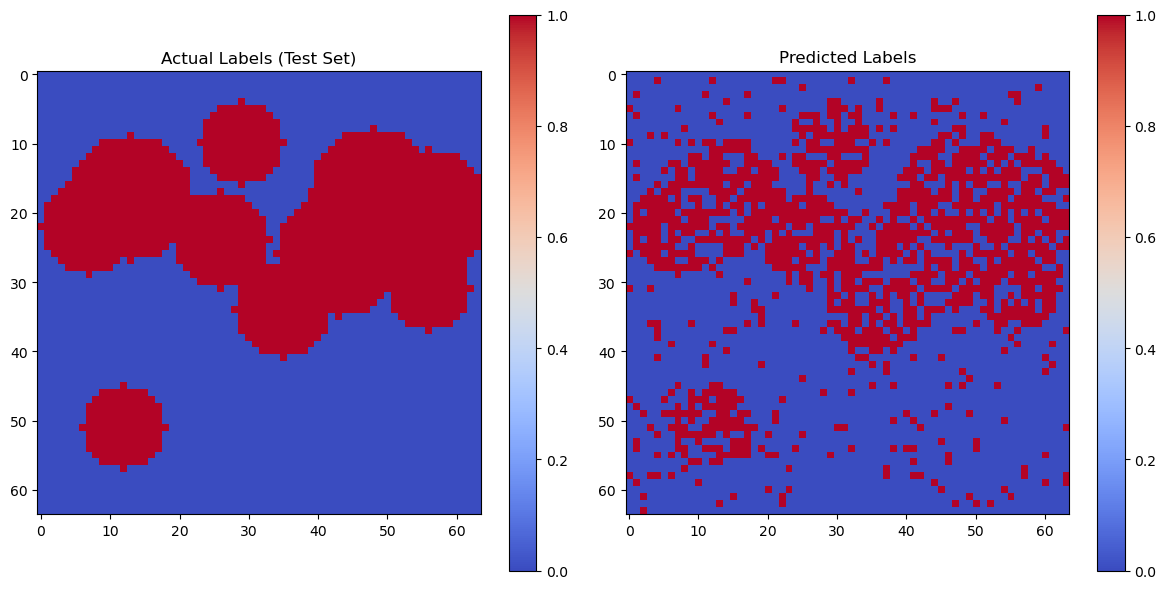

In [37]:
plot_label_comparison(test_spatial_y, predictions_test, grid_size)